# HVG:seurat_v3 & harmony workflow
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working rapids environment with all nessaray dependencies. Run the [data_downloader](https://github.com/scverse/rapids_singlecell-notebooks/blob/abc4fc6f3fe7f85cbffb94e76d190cad0ae00a5f/data_downloader.ipynb) notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Load and Prepare Data

Let's start by ensuring that we have our dataset downloaded.

In [3]:
import gdown
import os
import wget

data_dir = "./h5"
final = data_dir+'/adata.raw.h5ad'
if not os.path.exists(data_dir): # Check if h5 directory exists
    print('creating data directory')
    os.system('mkdir ./h5')
else:
    print(f'{data_dir} directory found')

if not os.path.isfile(final): # Check to see if we have our final output.  If it is there, get to the analysis!
    print('Downloading cell data..')
    url = 'https://drive.google.com/file/d/1eoK0m2ML1uNLc80L6yBuPrkJqsDF-QWj/view?usp=sharing'
    gdown.download(url, output, quiet=True, fuzzy=True)
else:
    print(f'{final} dataset found')

./h5 directory found
./h5/adata.raw.h5ad dataset found


We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [4]:
data_load_start = time.time()

In [5]:
%%time
adata = sc.read(final)

CPU times: user 3.27 s, sys: 379 ms, total: 3.65 s
Wall time: 3.64 s


In [6]:
%%time
rsc.get.anndata_to_GPU(adata)

CPU times: user 76.6 ms, sys: 374 ms, total: 451 ms
Wall time: 450 ms


In [7]:
adata.shape

(93575, 33694)

Verify the shape of the resulting sparse matrix:

In [8]:
adata.shape

(93575, 33694)

In [9]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time - data_load_start))

Total data load and format time: 4.113630056381226


## Preprocessing

In [10]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [11]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="MT", gene_family_prefix="MT-")

CPU times: user 5.39 ms, sys: 123 μs, total: 5.51 ms
Wall time: 5.41 ms


In [12]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 5.3 ms, sys: 0 ns, total: 5.3 ms
Wall time: 5.15 ms


In [13]:
%%time
rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT", "RIBO"])

CPU times: user 50.4 ms, sys: 2.97 ms, total: 53.4 ms
Wall time: 52.9 ms


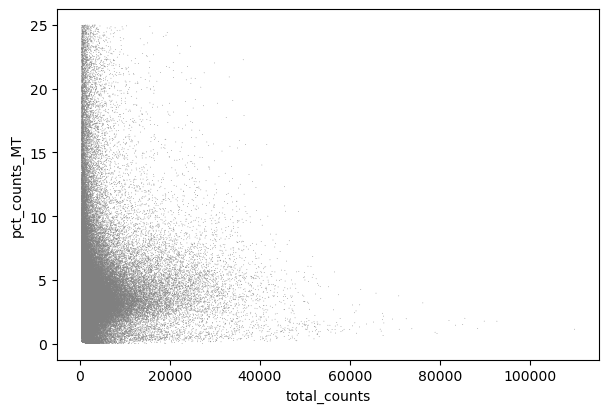

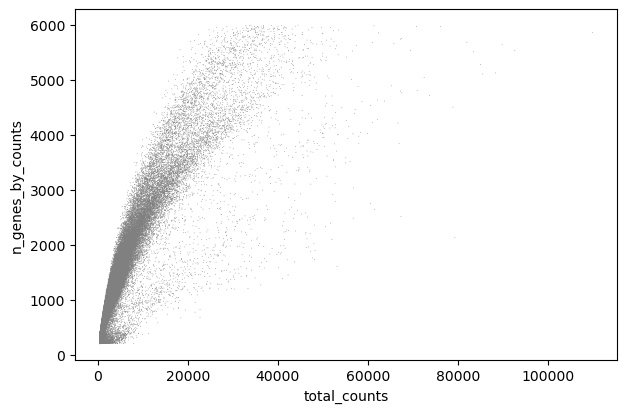

In [14]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_MT")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

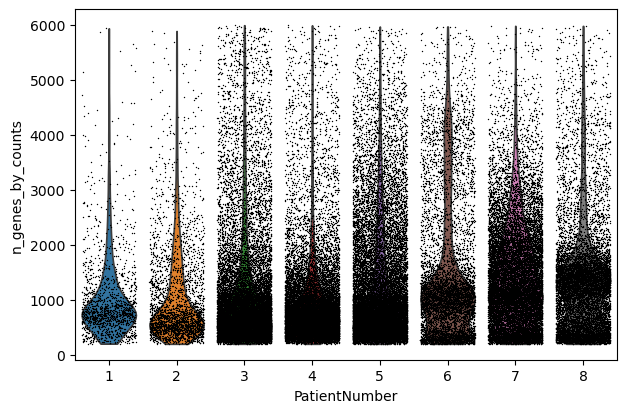

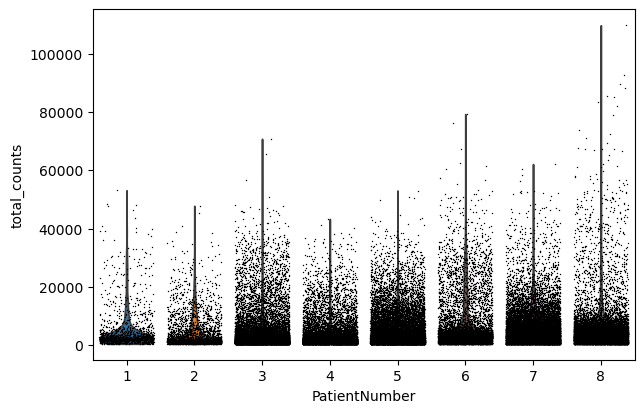

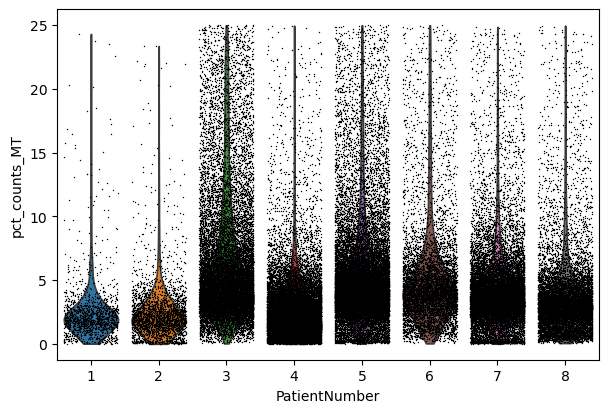

In [15]:
sc.pl.violin(adata, "n_genes_by_counts", jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, "total_counts", jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, "pct_counts_MT", jitter=0.4, groupby="PatientNumber")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [16]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] > 200]
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata.shape

CPU times: user 29.1 ms, sys: 2.03 ms, total: 31.1 ms
Wall time: 30.5 ms


(92666, 33694)

In [17]:
%%time
adata = adata[adata.obs["pct_counts_MT"] < 20]
adata.shape

CPU times: user 12.1 ms, sys: 3.62 ms, total: 15.7 ms
Wall time: 15.2 ms


(91180, 33694)

We also filter out genes that are expressed in less than 3 cells.

In [18]:
%%time
rsc.pp.filter_genes(adata, min_count=3)

filtered out 8034 genes based on n_cells_by_counts
CPU times: user 110 ms, sys: 41.1 ms, total: 151 ms
Wall time: 151 ms


We store the raw expression counts in the `.layer["counts"]`

In [19]:
adata.layers["counts"] = adata.X.copy()

In [20]:
adata.shape

(91180, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [21]:
%%time
rsc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 171 μs, sys: 1.07 ms, total: 1.24 ms
Wall time: 1.01 ms


Next, we log transform the count matrix.

In [22]:
%%time
rsc.pp.log1p(adata)

CPU times: user 334 μs, sys: 734 μs, total: 1.07 ms
Wall time: 772 μs


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [23]:
%%time
rsc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    flavor="seurat_v3",
    batch_key="PatientNumber",
    layer="counts",
)

CPU times: user 2.11 s, sys: 124 ms, total: 2.23 s
Wall time: 2.23 s


Now we safe this version of the AnnData as adata.raw.

In [24]:
%%time
adata.raw = adata

CPU times: user 110 ms, sys: 128 ms, total: 238 ms
Wall time: 237 ms


Now we restrict our AnnData object to the highly variable genes.

In [25]:
%%time
adata = adata[:, adata.var["highly_variable"]]

CPU times: user 110 ms, sys: 130 ms, total: 240 ms
Wall time: 239 ms


In [26]:
adata.shape

(91180, 5000)

Next we regress out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [27]:
%%time
rsc.pp.regress_out(adata, keys=["total_counts", "pct_counts_MT"])

CPU times: user 1.97 s, sys: 242 ms, total: 2.22 s
Wall time: 2.22 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [28]:
%%time
rsc.pp.scale(adata, max_value=10)

CPU times: user 189 ms, sys: 2.19 ms, total: 191 ms
Wall time: 190 ms


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from cuMLs.

In [29]:
%%time
rsc.pp.pca(adata, n_comps=100)

CPU times: user 1.25 s, sys: 128 ms, total: 1.38 s
Wall time: 1.37 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

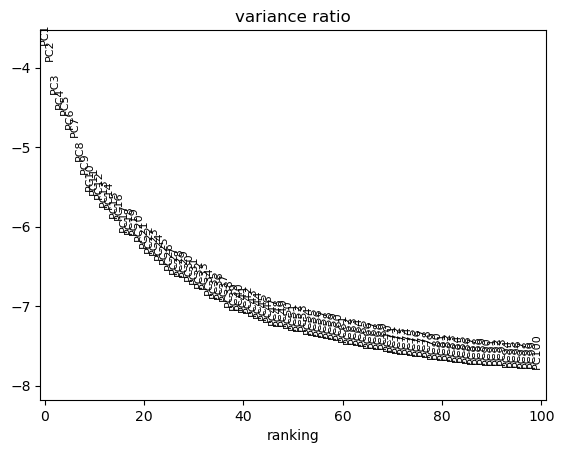

In [30]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

Now we move `.X` and `.layers` out of the GPU.

In [31]:
%%time
rsc.get.anndata_to_CPU(adata, convert_all=True)

CPU times: user 253 ms, sys: 309 ms, total: 563 ms
Wall time: 561 ms


In [32]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time - preprocess_start))

Total Preprocessing time: 10.108124732971191


We have now finished the preprocessing of the data.

## Batch Correction

In [33]:
%%time
rsc.pp.harmony_integrate(adata, key="PatientNumber", dtype = cp.float32)

CPU times: user 3.64 s, sys: 55 ms, total: 3.69 s
Wall time: 3.7 s


## Clustering and Visualization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the exact graph. Both methods are valid, but you might see differences.

In [34]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 331 ms, sys: 178 ms, total: 509 ms
Wall time: 508 ms


Next we calculate the UMAP embedding using rapdis.

In [35]:
%%time
rsc.tl.umap(adata)

CPU times: user 203 ms, sys: 23.2 ms, total: 226 ms
Wall time: 318 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [36]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 870 ms, sys: 111 ms, total: 980 ms
Wall time: 979 ms


In [37]:
%%time
rsc.tl.leiden(adata, resolution=0.6)

CPU times: user 571 ms, sys: 39.2 ms, total: 610 ms
Wall time: 609 ms


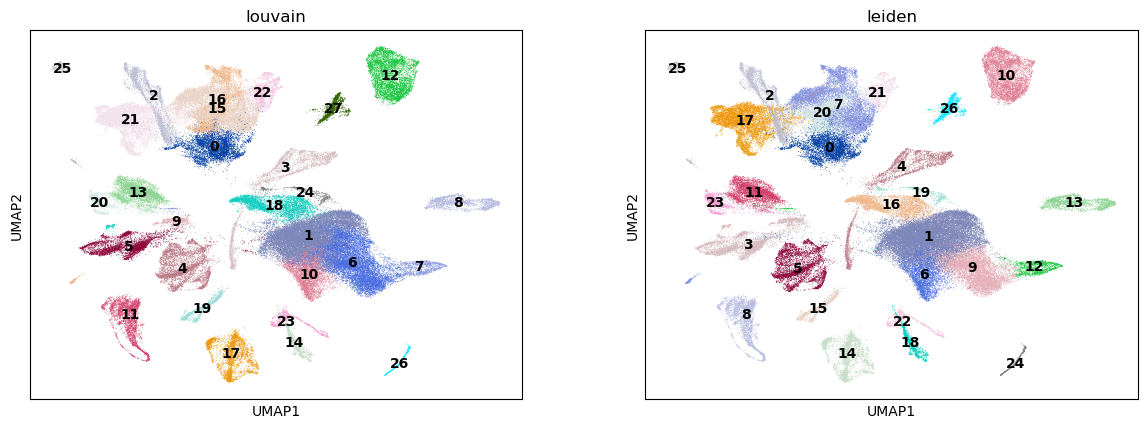

CPU times: user 695 ms, sys: 187 ms, total: 882 ms
Wall time: 674 ms


In [38]:
%%time
sc.pl.umap(adata, color=["louvain", "leiden"], legend_loc="on data")

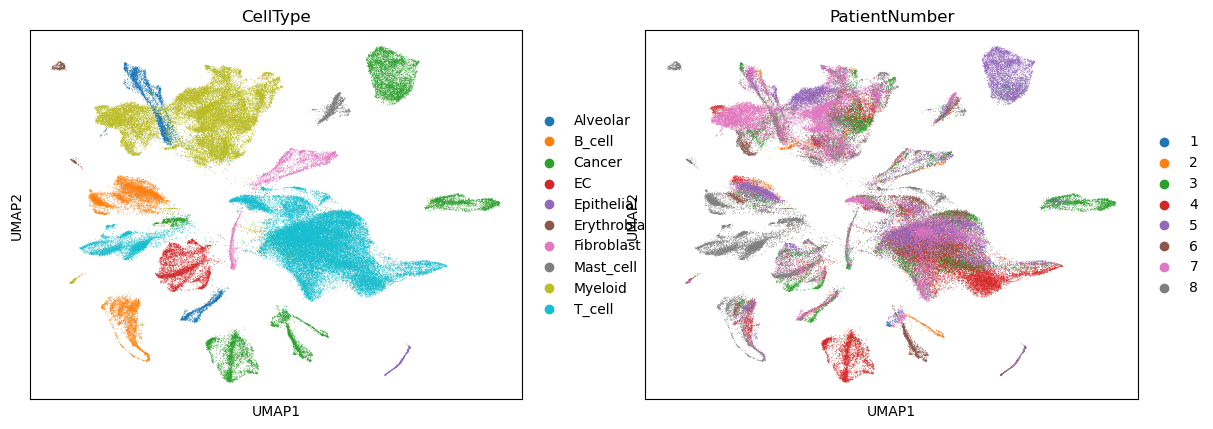

In [39]:
sc.pl.umap(adata, color=["CellType", "PatientNumber"])

We also calculate the embedding density in the UMAP using cuML

In [40]:
%%time
rsc.tl.embedding_density(adata, groupby="PatientNumber")

CPU times: user 2.27 s, sys: 48.3 ms, total: 2.32 s
Wall time: 2.32 s


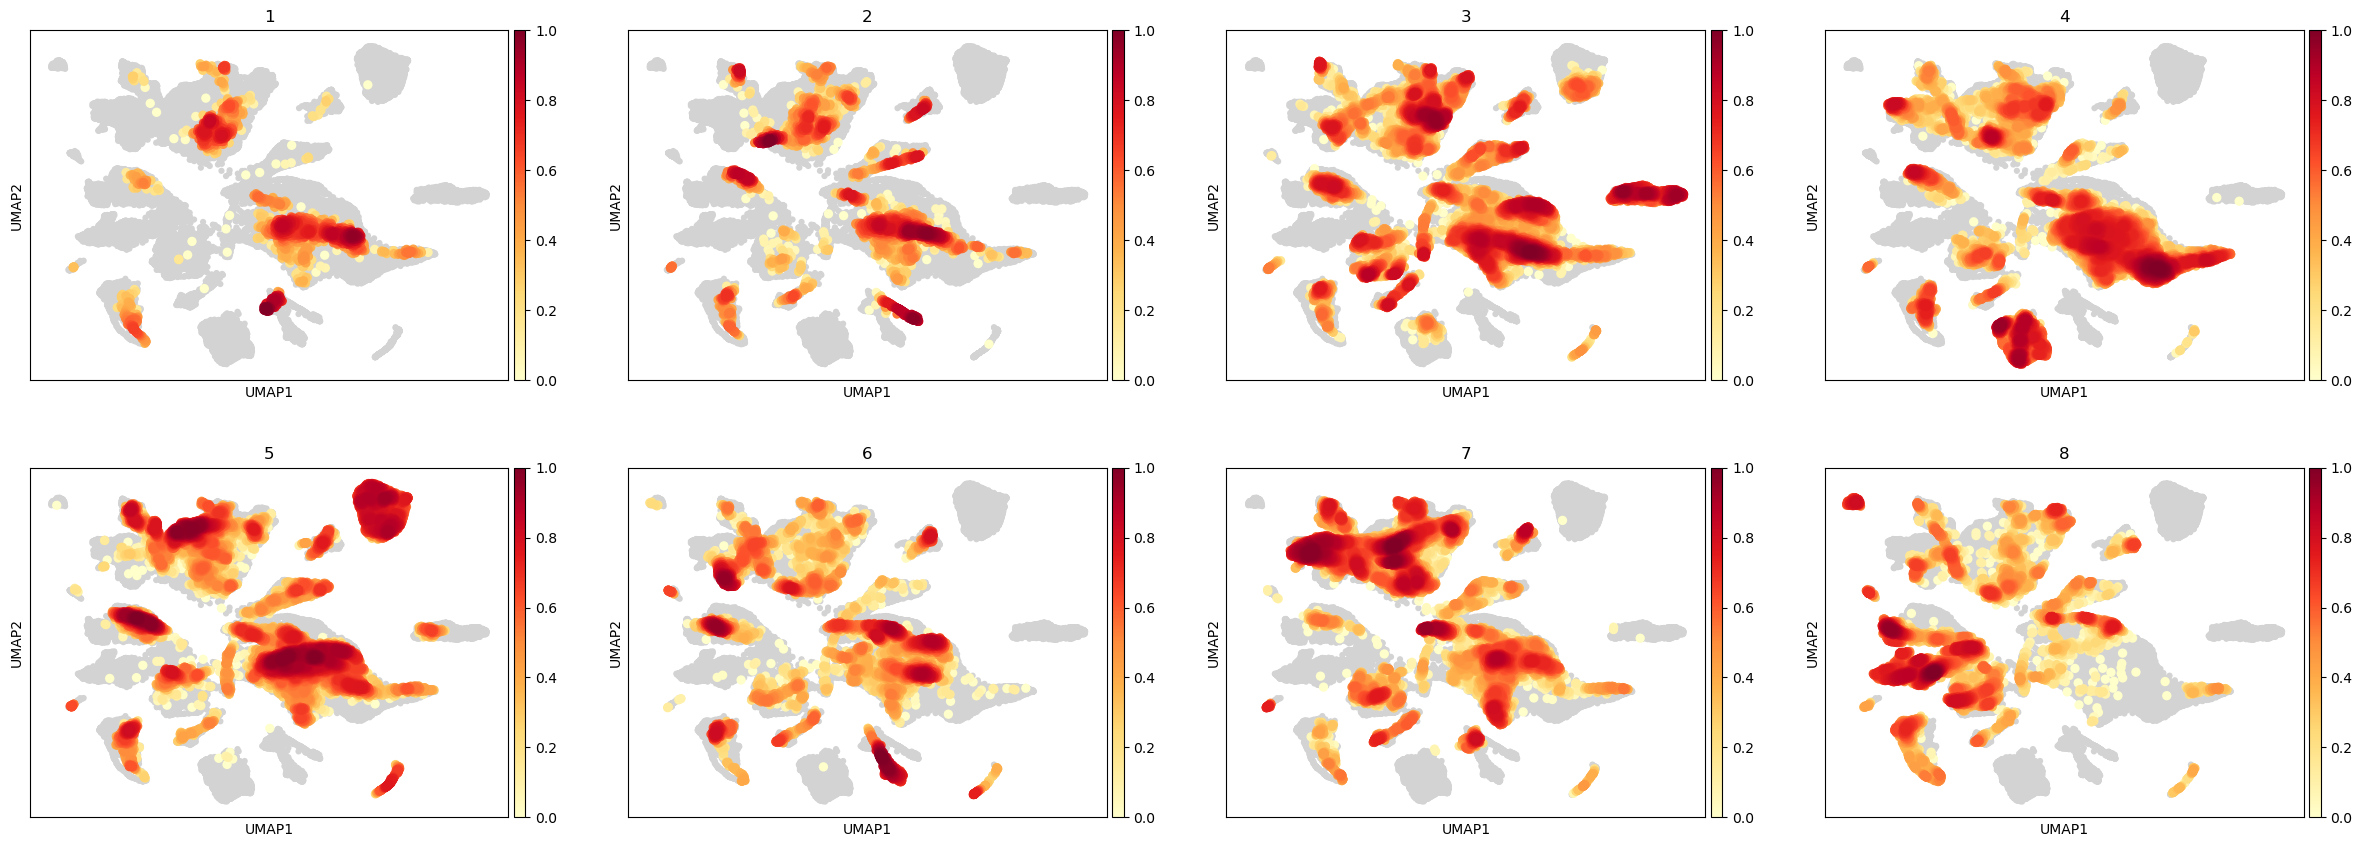

In [41]:
sc.pl.embedding_density(adata, groupby="PatientNumber")

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [42]:
%%time
rsc.tl.tsne(adata, n_pcs=40)

[W] [19:12:20.984869] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1.25 s, sys: 1.11 s, total: 2.36 s
Wall time: 2.35 s


In [43]:
rsc.tl.kmeans(adata, n_clusters=8)

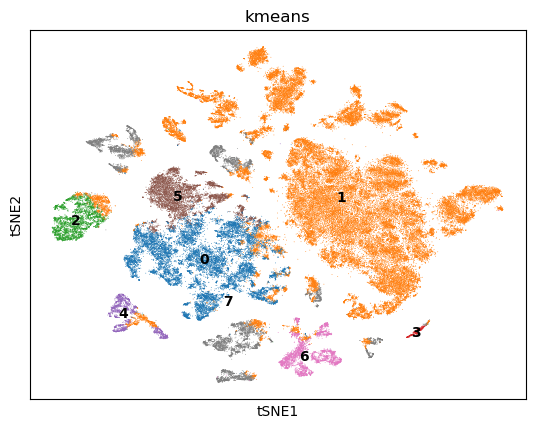

CPU times: user 365 ms, sys: 176 ms, total: 541 ms
Wall time: 350 ms


In [44]:
%%time
sc.pl.tsne(adata, color=["kmeans"], legend_loc="on data")

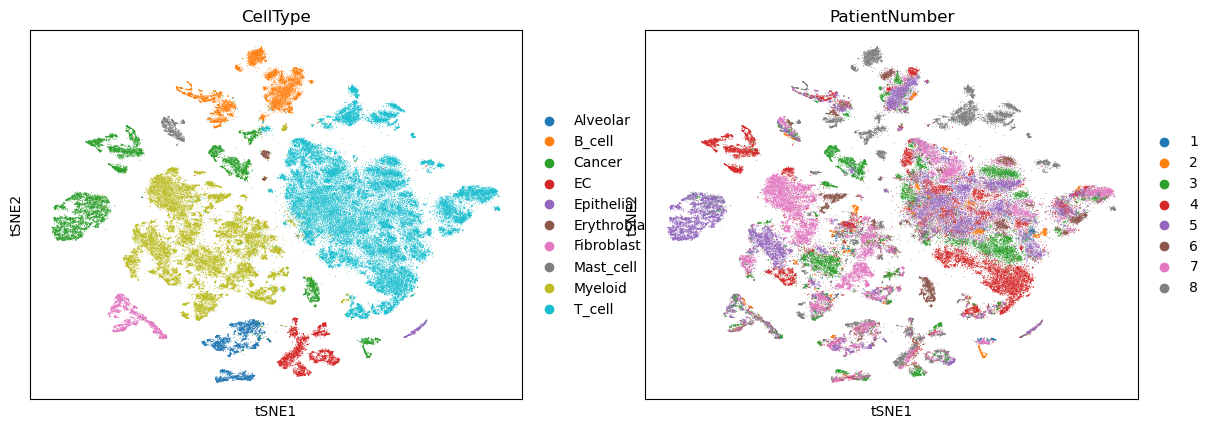

In [45]:
sc.pl.tsne(adata, color=["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [46]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

CPU times: user 3.18 s, sys: 1.64 s, total: 4.82 s
Wall time: 4.81 s


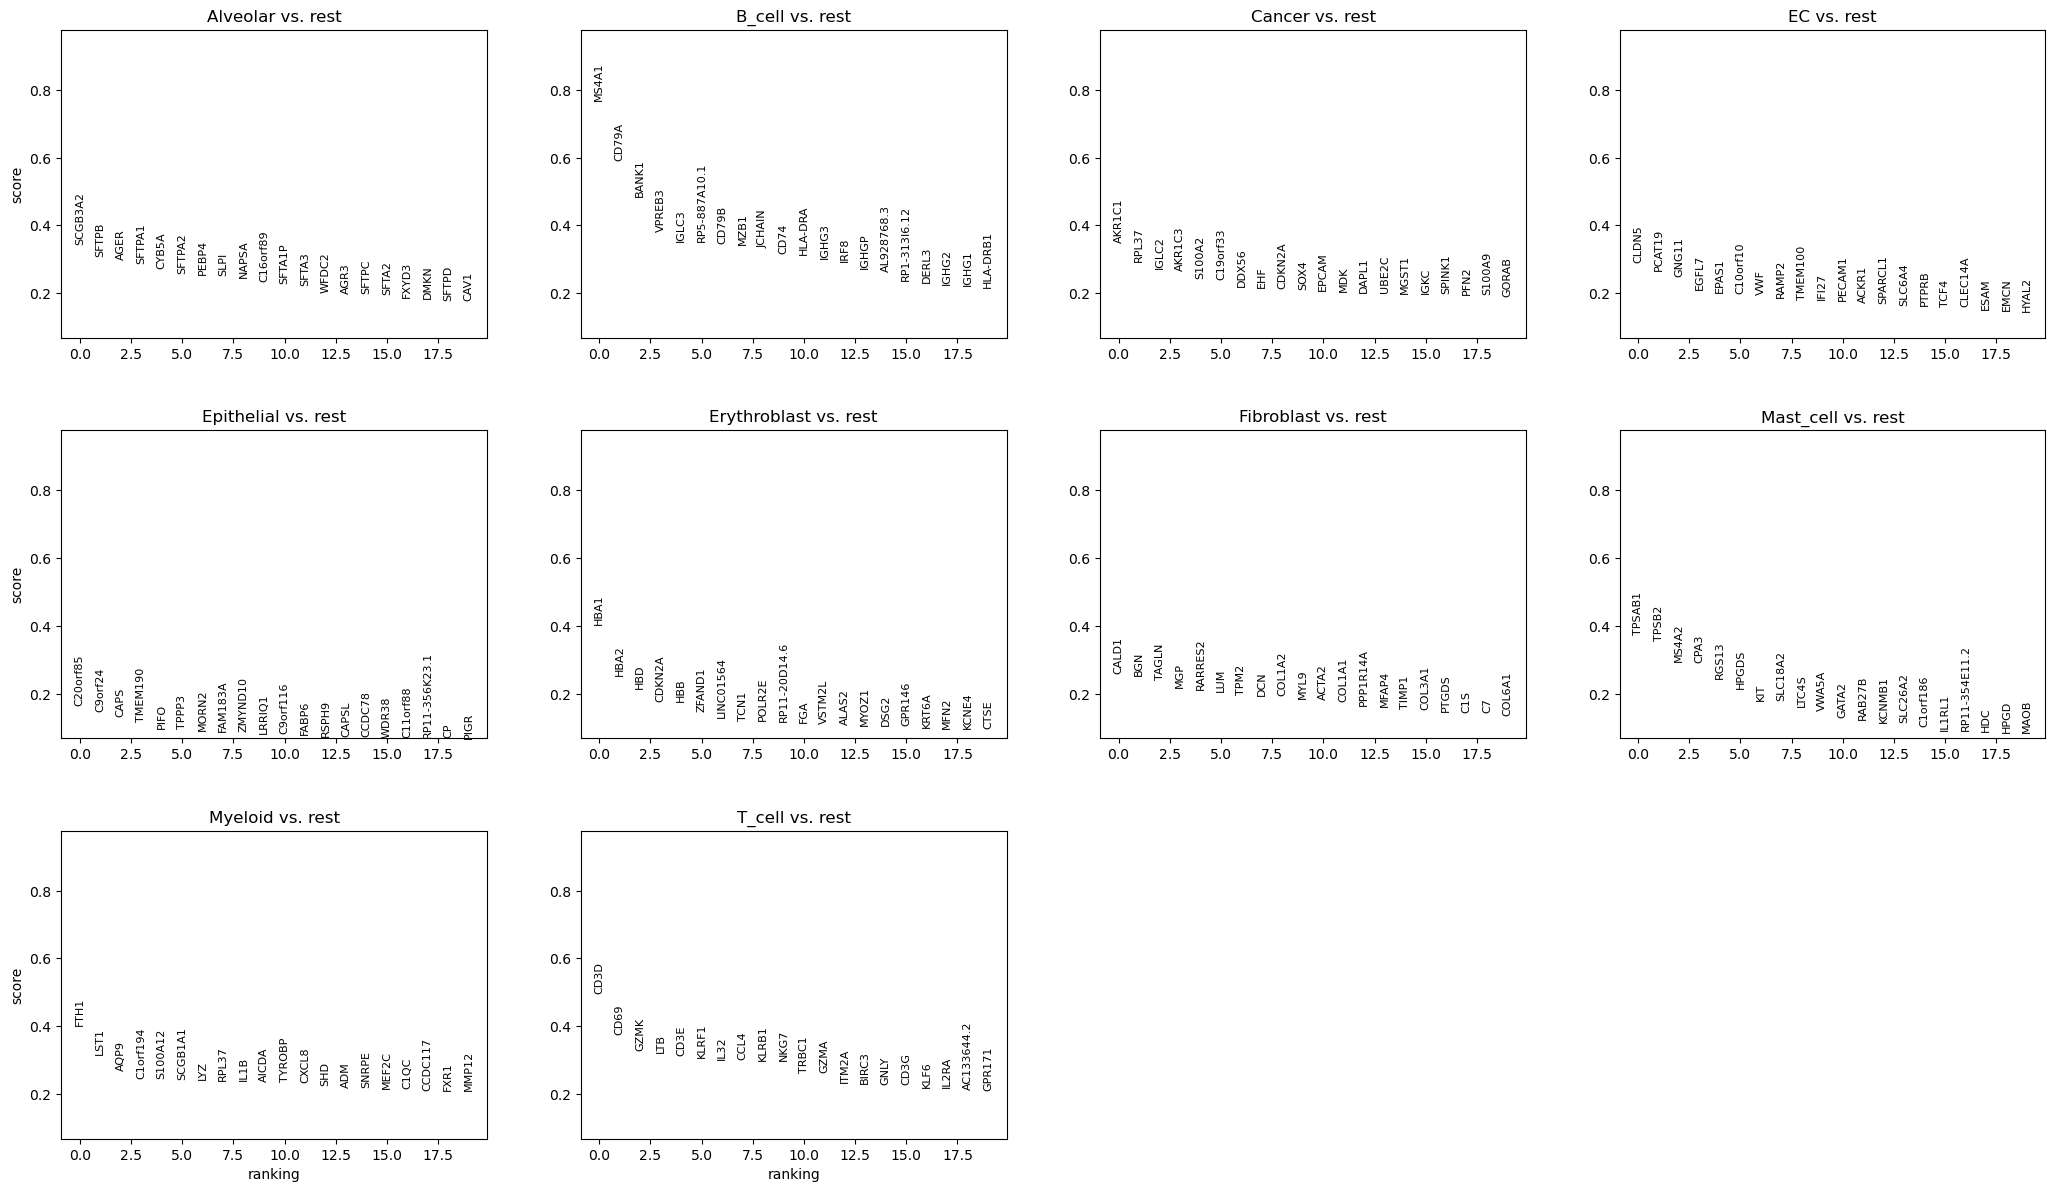

CPU times: user 839 ms, sys: 195 ms, total: 1.03 s
Wall time: 823 ms


In [47]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [48]:
post_time = time.time()

In [49]:
print("Total Postprocessing time: %s" % (post_time - preprocess_time))

Total Postprocessing time: 22.43779945373535


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [50]:
tdata = adata[adata.obs["CellType"] == "T_cell", :].copy()

We can repeat the dimension reduction, clustering and visulatization.

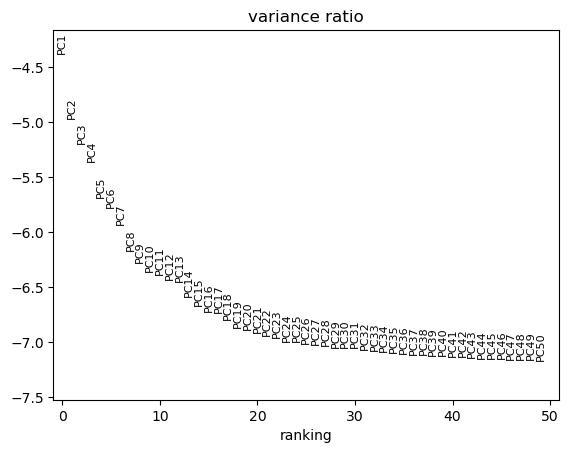

CPU times: user 1.35 s, sys: 736 ms, total: 2.09 s
Wall time: 1.89 s


In [51]:
%%time
rsc.tl.pca(tdata, n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True, n_pcs=50)

In [52]:
%%time
rsc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20)
rsc.tl.umap(tdata)
rsc.tl.louvain(tdata)

CPU times: user 393 ms, sys: 32.5 ms, total: 425 ms
Wall time: 419 ms


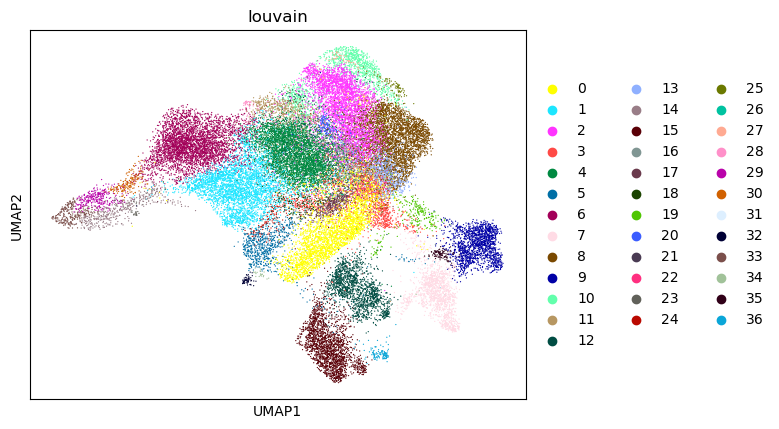

In [53]:
sc.pl.umap(tdata, color=["louvain"])

As stated before Diffusion Maps have become an integral part of single cell analysis.

In [54]:
%%time
rsc.tl.diffmap(tdata)

CPU times: user 169 ms, sys: 5.81 ms, total: 174 ms
Wall time: 173 ms


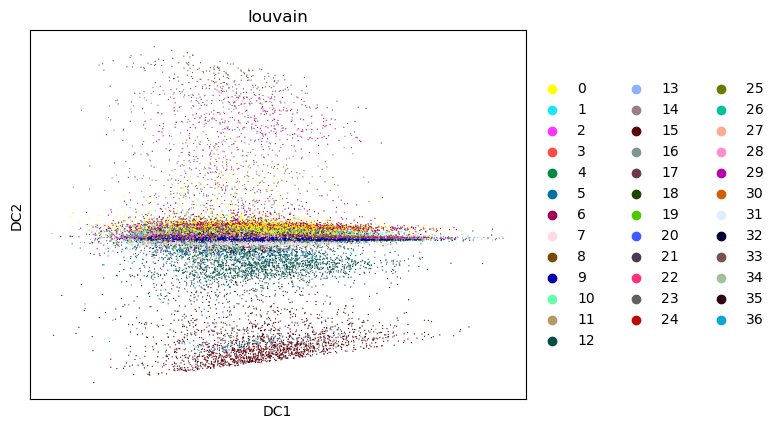

In [55]:
sc.pl.diffmap(tdata, color="louvain")

In [56]:
%%time
rsc.tl.draw_graph(tdata)

CPU times: user 298 ms, sys: 30.9 ms, total: 329 ms
Wall time: 330 ms


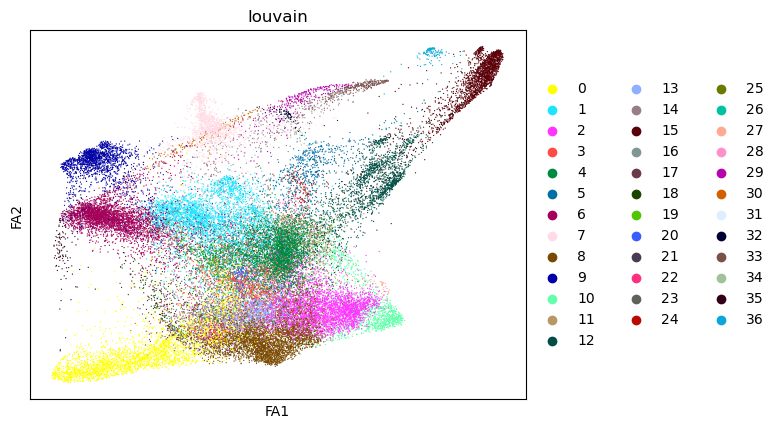

In [57]:
sc.pl.draw_graph(tdata, color="louvain")

After this you can use `X_diffmap` for `sc.pp.neighbors` and other functions. 

In [58]:
print("Total Processing time: %s" % (time.time() - preprocess_start))

Total Processing time: 37.91391110420227
